In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from loader import *
from models import *
from utils import *
from plotting import *

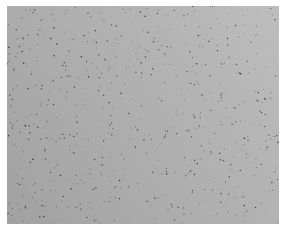

In [7]:

moving_prey = moving_spherical_plankton(im_size_height=512, 
                                            im_size_width=640, 
                                            radius=0.2e-6, 
                                            label=0, 
                                            diffusion_constant_coeff=1.3)

stationary_prey = stationary_spherical_plankton(im_size_height=512, 
                                                    im_size_width=640, 
                                                    radius=0.2e-6, 
                                                    label=-1)

moving_predator = moving_spherical_plankton(im_size_height=512, 
                                            im_size_width=640, 
                                            radius=0.3e-6, 
                                            label=0, 
                                            diffusion_constant_coeff=8)

stationary_predator = stationary_spherical_plankton(im_size_height=512, 
                                                    im_size_width=640, 
                                                    radius=0.3e-6, 
                                                    label=-1)


sequential_moving_prey = Sequential(moving_prey, position=get_position_moving_plankton)
sequential_stationary_prey = Sequential(stationary_prey, position=get_position_stationary_plankton)
sequential_moving_predator = Sequential(moving_predator, position=get_position_moving_plankton)
sequential_stationary_predator = Sequential(stationary_predator, position=get_position_stationary_plankton)

microscope = plankton_brightfield(im_size_height=512, 
                                  im_size_width=640, 
                                  gradient_amp=0.1)

no_of_moving_prey, no_of_stationary_prey, no_of_moving_predators, no_of_stationary_predators = 75, 600, 75, 180

sample = create_sample(sequential_moving_prey, no_of_moving_prey, 
                       sequential_stationary_prey, no_of_stationary_prey,
                       sequential_moving_predator, no_of_moving_predators, 
                       sequential_stationary_predator, no_of_stationary_predators) 

noise_amp = 0.1
norm_min, norm_max= 0, 1
sequence = create_sequence(noise_amp, sample, microscope, norm_min, norm_max)

sequence_length = 2
imaged_particle_sequence = Sequence(sequence, sequence_length=sequence_length)

imaged_particle_sequence.plot(cmap='gray')

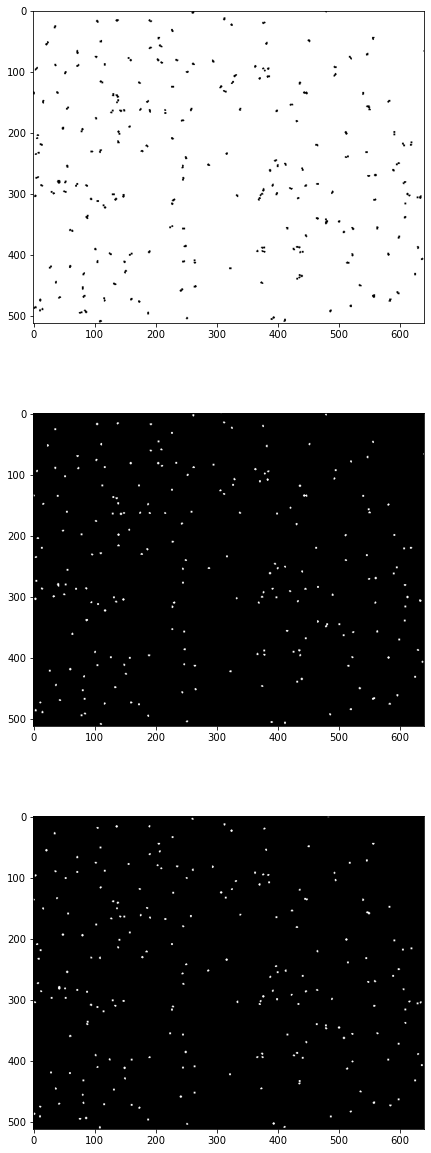

In [14]:
label = get_target_sequence(imaged_particle_sequence.resolve())
label_function = get_target_sequence
plot_label(label_function, imaged_particle_sequence)

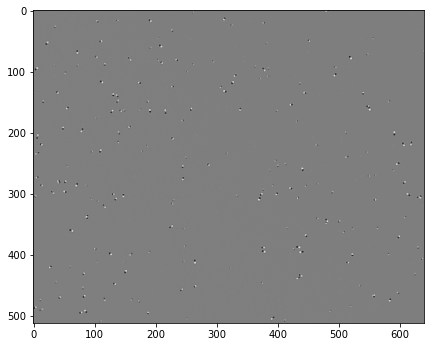

In [15]:
batch_function = create_custom_batch_function(imaged_particle_sequence, 
                                              outputs=[[0,1]], 
                                              function_img=[Normalize_image],
                                              function_diff=[Normalize_image])


train_images = batch_function(imaged_particle_sequence.resolve())

plot_batch(train_images)

In [16]:
from deeptrack.generators import ContinuousGenerator
generator = ContinuousGenerator(
    imaged_particle_sequence,
    get_target_sequence,
    batch_function,
    batch_size=8,
    min_data_size=80,
    max_data_size=512
    )

In [18]:
model = generate_unet(im_size_height=512, 
                      im_size_width=640, 
                      no_of_inputs=1, 
                      no_of_outputs=3)

In [19]:
model = train_model_early_stopping(model, 
                                   generator, 
                                   patience=10, 
                                   epochs=100, 
                                   steps_per_epoch=10)

Generating 80 / 80 samples before starting training
Epoch 1/100
10/10 [==============================] - 3s 319ms/step - loss: 0.0095
Epoch 2/100
10/10 [==============================] - 3s 312ms/step - loss: 0.0093
Epoch 3/100
10/10 [==============================] - 3s 316ms/step - loss: 0.0089
Epoch 4/100
10/10 [==============================] - 3s 323ms/step - loss: 0.0072
Epoch 5/100
10/10 [==============================] - 3s 302ms/step - loss: 0.0047
Epoch 6/100
10/10 [==============================] - 3s 306ms/step - loss: 0.0034
Epoch 7/100
10/10 [==============================] - 3s 302ms/step - loss: 0.0030
Epoch 8/100
10/10 [==============================] - 3s 314ms/step - loss: 0.0026
Epoch 9/100
10/10 [==============================] - 3s 316ms/step - loss: 0.0024
Epoch 10/100
10/10 [==============================] - 3s 324ms/step - loss: 0.0023
Epoch 11/100
10/10 [==============================] - 3s 306ms/step - loss: 0.0022
Epoch 12/100
10/10 [========================

10/10 [==============================] - 3s 311ms/step - loss: 0.0013
Epoch 100/100
10/10 [==============================] - 3s 314ms/step - loss: 0.0013


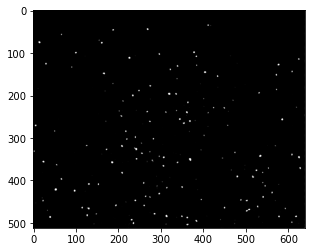

In [46]:
# change outputs
folder_path = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\Test simulations\\raw_output\\raw_output_images'
im_stack = get_image_stack(
    outputs=[[0,1]], 
    folder_path=folder_path, 
    frame_im0=0, 
    im_size_width=640, 
    im_size_height=512,
    im_resize_width=640, 
    im_resize_height=512,
    function_img=[Normalize_image],
    function_diff=[Normalize_image])

# plot_im_stack(im_stack)
# plot_prediction(model=model, im_stack=im_stack)
plt.imshow(model.predict(im_stack)[0,:,:,1], cmap='gray')

In [48]:
positions = extract_positions(
    no_of_frames=49, 
    outputs=[[0,1]], 
    folder_path=folder_path, 
    frame_im0=0, 
    im_size_width=640, 
    im_size_height=512,
    im_resize_width=640, 
    im_resize_height=512,
    model=model, 
    layer=2, 
    value_threshold=0.6,
    function_img=[Normalize_image],
    function_diff=[Normalize_image])


In [51]:
list_of_plankton = assign_positions_to_planktons(positions, max_dist=10, threshold = 5, extrapolate=True)
list_of_plankton = Interpolate_gaps_in_plankton_positions(list_of_plankton=list_of_plankton)
list_of_plankton = Trim_list_from_stationary_planktons(list_of_plankton=list_of_plankton, min_distance=25)

plankton_track, plankton_dont_track = split_plankton(percentage_threshold=0.2, list_of_plankton=list_of_plankton)

In [56]:
plot_and_save_track(no_of_frames = len(list_of_plankton[list(list_of_plankton.keys())[0]].positions),
                    plankton_track = plankton_track,
                    plankton_dont_track = plankton_dont_track,
                    folder_path = folder_path,
                    frame_im0 = 0,
                    save_images=1,
                    show_plankton_track = True,
                    show_plankton_dont_track = 0,
                    show_numbers_track = 0,
                    show_numbers_dont_track = 0,
                    show_numbers_specific_plankton = False,
                    show_specific_plankton = False,
                    specific_plankton = None,
                    color_plankton_track = 'b',
                    color_plankton_dont_track = 'r',
                    color_specific_plankton = 'w',
                    save_path = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output',
                    frame_name = 'track',
                    file_type = '.jpg')

In [57]:
Make_video(frame_im0=0,
           folder_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output', 
           save_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Test_video.avi', 
           fps=7, 
           no_of_frames=49)